In [1]:
# turn off pink warning boxes
import warnings
warnings.filterwarnings("ignore")

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm
import itertools as it

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

#important import 
import pandas as pd
import numpy as np
import os
import wrangle as w

In [2]:
# plotting defaults
plt.rc('figure', figsize=(16, 7))
plt.style.use('seaborn-dark-palette')
plt.rc('font', size=16)

In [3]:
#Acquire superstore data from codeup database
df = w.get_superstore_data()

In [4]:
df.head()

,Region ID,Category ID,Product ID,Customer ID,Order ID,Order Date,Ship Date,Ship Mode,Segment,Country,...,Postal Code,Sales,Quantity,Discount,Profit,Customer Name,Product Name,Category,Sub-Category,Region Name
0,1,1,FUR-BO-10001798,CG-12520,CA-2016-152156,2016-11-08,2016-11-11,Second Class,Consumer,United States,...,42420.0,261.9600,2.0,0.00,41.9136,Claire Gute,Bush Somerset Collection Bookcase,Furniture,Bookcases,South
1,1,2,FUR-CH-10000454,CG-12520,CA-2016-152156,2016-11-08,2016-11-11,Second Class,Consumer,United States,...,42420.0,731.9400,3.0,0.00,219.5820,Claire Gute,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",Furniture,Chairs,South
2,1,4,FUR-TA-10000577,SO-20335,US-2015-108966,2015-10-11,2015-10-18,Standard Class,Consumer,United States,...,33311.0,957.5775,5.0,0.45,-383.0310,Sean O'Donnell,Bretford CR4500 Series Slim Rectangular Table,Furniture,Tables,South
3,1,5,OFF-ST-10000760,SO-20335,US-2015-108966,2015-10-11,2015-10-18,Standard Class,Consumer,United States,...,33311.0,22.3680,2.0,0.20,2.5164,Sean O'Donnell,Eldon Fold 'N Roll Cart System,Office Supplies,Storage,South
4,1,11,OFF-PA-10002365,AA-10480,CA-2017-114412,2017-04-15,2017-04-20,Standard Class,Consumer,United States,...,28027.0,15.5520,3.0,0.20,5.4432,Andrew Allen,Xerox 1967,Office Supplies,Paper,South


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1734 entries, 0 to 1733
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Region ID      1734 non-null   int64  
 1   Category ID    1734 non-null   int64  
 2   Product ID     1734 non-null   object 
 3   Customer ID    1734 non-null   object 
 4   Order ID       1734 non-null   object 
 5   Order Date     1734 non-null   object 
 6   Ship Date      1734 non-null   object 
 7   Ship Mode      1734 non-null   object 
 8   Segment        1734 non-null   object 
 9   Country        1734 non-null   object 
 10  City           1734 non-null   object 
 11  State          1734 non-null   object 
 12  Postal Code    1734 non-null   float64
 13  Sales          1734 non-null   float64
 14  Quantity       1734 non-null   float64
 15  Discount       1734 non-null   float64
 16  Profit         1734 non-null   float64
 17  Customer Name  1734 non-null   object 
 18  Product 

In [6]:
#Checking the nulls
df.isnull().sum().sum()

0

In [7]:
#Cleaning superstore data
df = w.prep_superstore(df, 'Order Date', 'Ship Date')

In [8]:
#Check to see if function rename the columns correctly
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1734 entries, 2014-01-04 to 2017-12-30
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   product_id     1734 non-null   object        
 1   customer_id    1734 non-null   object        
 2   order_id       1734 non-null   object        
 3   ship_date      1734 non-null   datetime64[ns]
 4   ship_mode      1734 non-null   object        
 5   segment        1734 non-null   object        
 6   country        1734 non-null   object        
 7   city           1734 non-null   object        
 8   state          1734 non-null   object        
 9   postal_code    1734 non-null   float64       
 10  sales          1734 non-null   float64       
 11  quantity       1734 non-null   float64       
 12  discount       1734 non-null   float64       
 13  profit         1734 non-null   float64       
 14  customer_name  1734 non-null   object        
 15  pro

In [9]:
#Let's take a look about the statistics of numeric values in the data.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
postal_code,1734.0,53501.926182,32180.245224,1841.0000,19143.0000,50315.00000,85705.00000,98661.000
sales,1734.0,229.206358,532.862614,1.0800,16.6950,52.24500,209.91750,8159.952
quantity,1734.0,3.794694,2.297407,1.0000,2.0000,3.00000,5.00000,14.000
discount,1734.0,0.160110,0.206419,0.0000,0.0000,0.20000,0.20000,0.800
profit,1734.0,21.880351,202.891949,-3839.9904,1.7024,8.07305,27.41445,3177.475
year,1734.0,2015.679931,1.086921,2014.0000,2015.0000,2016.00000,2017.00000,2017.000


In [10]:
#Let's see how many categories of products we have in the data.
df.category.unique()

array(['Office Supplies', 'Technology', 'Furniture'], dtype=object)

In [11]:
df.category.value_counts()

Office Supplies    1055
Furniture           360
Technology          319
Name: category, dtype: int64

**Explore**

<AxesSubplot:xlabel='Order Date'>

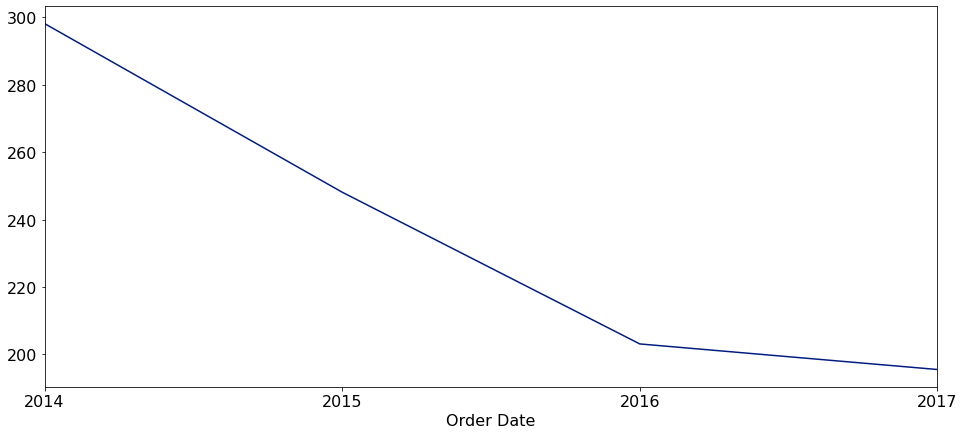

In [12]:
#Look at the sales over the years
df.resample('Y').sales.mean().plot()

<AxesSubplot:xlabel='Order Date'>

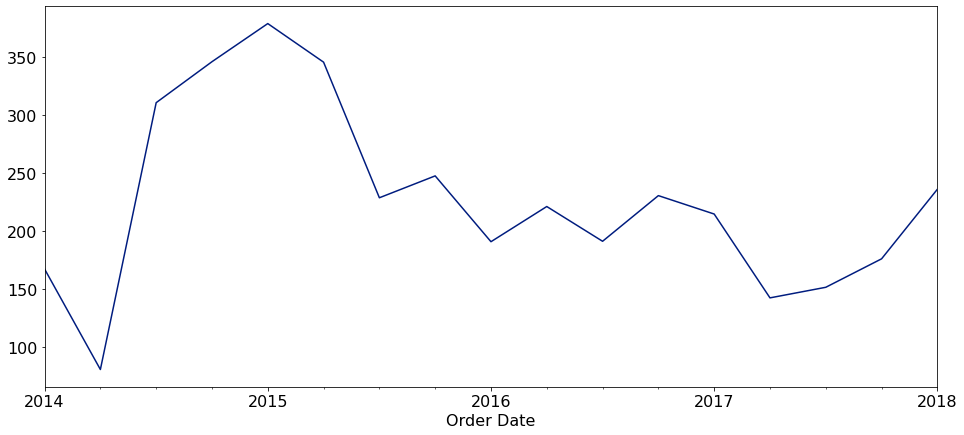

In [13]:
#Look at the sales for every 3 month
df.resample('3M').sales.mean().plot()

**Look deeper into category**

In [14]:
#Extract the data of Office Supplies
office_supplies = df.loc[df['category'] == 'Office Supplies']

In [15]:
#Want to see how many years of of sales data we having
office_supplies.index.min(), office_supplies.index.max()

(Timestamp('2014-01-04 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [16]:
office_supplies = office_supplies[['sales']]
office_supplies.head()

,sales
Order Date,
2014-01-04,11.784
2014-01-04,272.736
2014-01-04,3.540
2014-01-09,9.344
2014-01-10,2.890


In [17]:
office_supplies = office_supplies.sort_values('Order Date')
office_supplies = office_supplies.groupby('Order Date')['sales'].sum().reset_index()
office_supplies = office_supplies.set_index('Order Date')
office_supplies.head()

,sales
Order Date,
2014-01-04,288.060
2014-01-09,9.344
2014-01-10,2.890
2014-01-13,640.520
2014-01-16,48.660


In [18]:
#using the start of each month as the timestamp
monthly = office_supplies['sales'].resample('MS').mean()

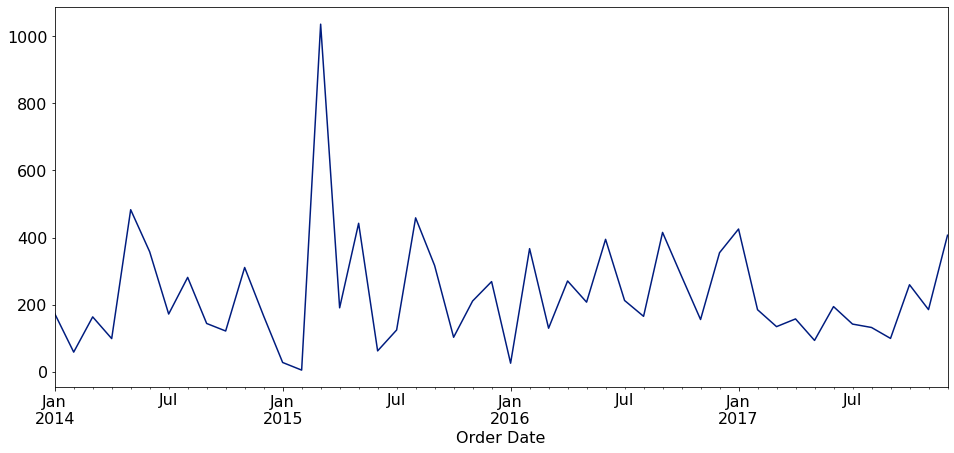

In [19]:
#Visualize the sales data
monthly.plot()
plt.show()

In [20]:
#Extract furniture
furniture = df.loc[df['category'] == 'Furniture']
furniture = furniture[['sales']]
furniture = furniture.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
furniture.head()

,sales
Order Date,
2014-01-10,51.940
2014-01-11,9.940
2014-01-16,127.104
2014-01-20,1106.540
2014-02-12,129.568


In [21]:
monthly_office = monthly
monthly_furniture = furniture['sales'].resample('MS').mean()

In [22]:
furniture = pd.DataFrame({'Order Date':monthly_furniture.index, 'Sales':monthly_furniture.values})
office = pd.DataFrame({'Order Date': monthly_office.index, 'Sales': monthly_office.values})

store = furniture.merge(office, how = 'inner', on = 'Order Date')
store.rename(columns = {'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,323.881000,173.734000
1,2014-02-01,129.568000,58.909500
2,2014-03-01,170.528000,163.820286
3,2014-04-01,86.112000,99.149250
4,2014-05-01,216.171333,483.108000


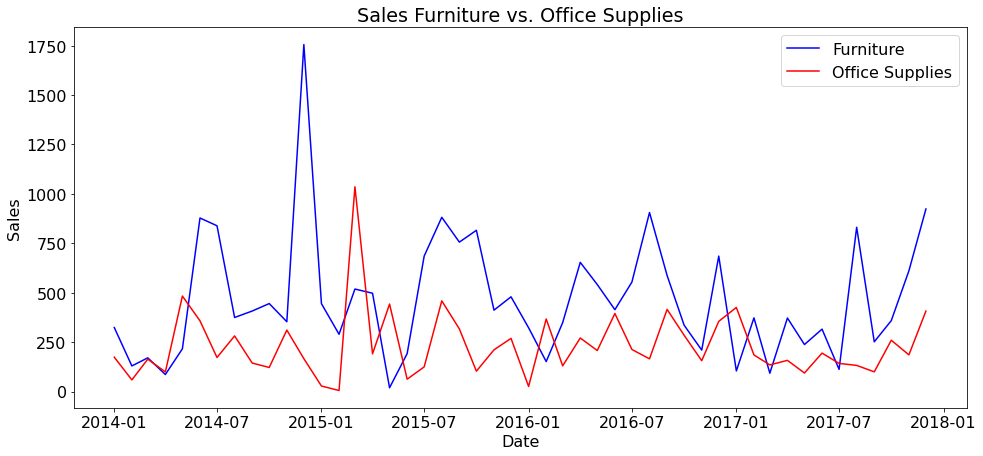

In [23]:
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'Furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'Office Supplies')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Furniture vs. Office Supplies')
plt.legend()
plt.show()

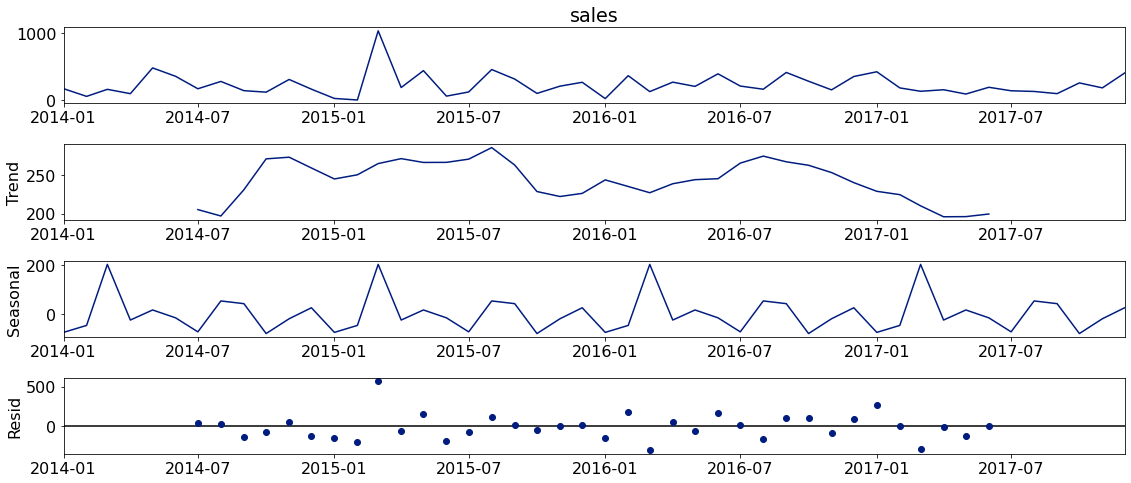

In [24]:
# Using decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.
sm.tsa.seasonal_decompose(monthly).plot()
None

The figure above clearly shows the seasonality in our data, and the trend is gradually increasing through the years.

**Modeling**

In [25]:
df = df[['sales']]

In [26]:
train, validate, test = w.split_time_series_data(df)

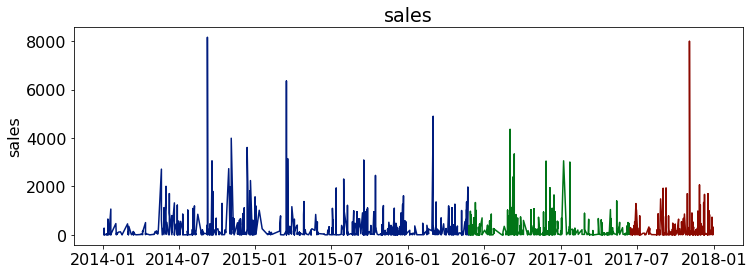

In [27]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [28]:
#From the lesson
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

def make_predictions():
    yhat_df = pd.DataFrame({'sales': [sales],
                           }, index = validate.index)
    return yhat_df

In [29]:
# create an empty dataframe to store model type, our avg_temp, and its rmse.
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


**Last observed value**

In [30]:
sales = train['sales'][-1:][0]
sales

41.37

In [31]:
#predictions based on last observed value
yhat_df = pd.DataFrame({'sales': [sales]},  
                      index = validate.index)

yhat_df.head()

,sales
Order Date,
2016-05-26,41.37
2016-05-26,41.37
2016-05-26,41.37
2016-05-26,41.37
2016-05-26,41.37


sales -- RMSE: 448


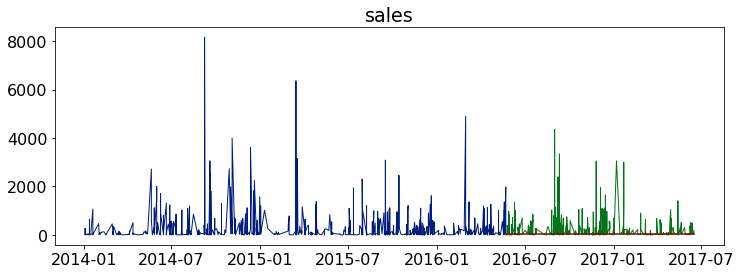

In [32]:
plot_and_eval('sales')

In [33]:
eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,sales,448.0


**Simple Average**

In [34]:
sales = round(train['sales'].mean(),2)
#predictions with simple average
yhat_df = pd.DataFrame({'sales': [sales]},  
                      index = validate.index)

sales -- RMSE: 426


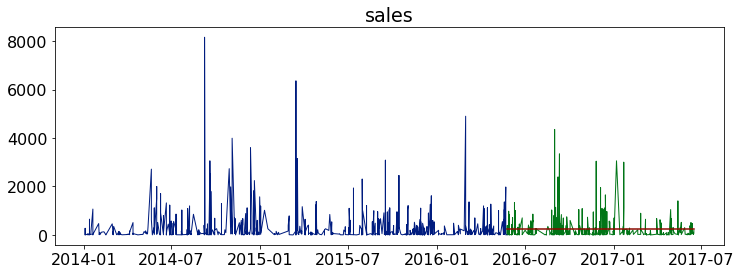

In [35]:
plot_and_eval(col)

In [36]:
eval_df = append_eval_df(model_type='simple_average', target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,sales,448.0
1,simple_average,sales,426.0


**Moving Average**

In [37]:
#Sales for 3 months
sales = round(train['sales'].rolling(3).mean()[-1], 2)
yhat_df = make_predictions()

sales -- RMSE: 455


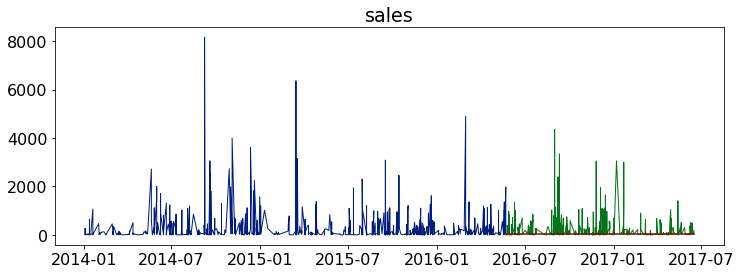

In [38]:
plot_and_eval('sales')

In [39]:
eval_df = append_eval_df(model_type='3 month moving average', target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,sales,448.0
1,simple_average,sales,426.0
2,3 month moving average,sales,455.0


In [40]:
#What about 6months, one year, two years and so on for moving average
periods = [6, 9, 12, 24, 36, 48]

for p in periods:
    sales = round(train['sales'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + ' month moving average'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type, 
                                 target_var = col)

In [41]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,sales,448.0
1,simple_average,sales,426.0
2,3 month moving average,sales,455.0
3,6 month moving average,sales,448.0
4,9 month moving average,sales,453.0
5,12 month moving average,sales,464.0
6,24 month moving average,sales,431.0
7,36 month moving average,sales,423.0
8,48 month moving average,sales,423.0


In [42]:
min_rmse_amount = eval_df.groupby('target_var')['rmse'].min()[0]

In [43]:
eval_df[((eval_df.rmse == min_rmse_amount))]

,model_type,target_var,rmse
7,36 month moving average,sales,423.0
8,48 month moving average,sales,423.0


**Holt's**

In [44]:
validate.index[-1],validate.index[0]

(Timestamp('2017-06-16 00:00:00'), Timestamp('2016-05-26 00:00:00'))

In [45]:
validate.tail()

,sales
Order Date,
2017-06-13,164.736
2017-06-15,47.976
2017-06-15,19.560
2017-06-16,65.990
2017-06-16,191.980


In [46]:
validate.shape

(520, 1)

In [54]:
for col in train.columns:
    model = Holt(train[col], exponential=False)
    model = model.fit(smoothing_level=0.1,
                      smoothing_slope = 0.1,
                      optimized=False)
    yhat_items = model.predict(start = validate.index[0], end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'